# Notebook 3:  Minhashing
***

In this notebook we'll practice computing similarity exactly using Jaccard similarity, and try out minhashing as a means to estimate the Jaccard similarity in a more computationally efficient manner. 

We'll need Numpy and Pandas for this notebook, so let's load them.

In [1]:
import numpy as np 
import pandas as pd

We will also be plotting using Matplotlib's Pyplot, so we can import that as well.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1:  Exact Similarities

Suppose for a set of 5 friends, there are 10 movies that each person either has or has not seen. We can construct a synthetic set of data by generating a characteristic matrix of 0s and 1s for the friends:

In [3]:
p = 0.65
nrow = 10
ncol = 5
np.random.seed(2019)
C = np.random.choice([1, 0], size=(nrow, ncol), p=[p, 1-p])
dfC = pd.DataFrame(C, columns=['Anya','Bahati','Cyril','Dack','Eloise'])
print(dfC)

   Anya  Bahati  Cyril  Dack  Eloise
0     0       1      1     1       0
1     1       0      0     0       1
2     1       1      1     0       1
3     0       1      1     1       0
4     1       1      1     0       1
5     1       1      1     1       1
6     0       0      0     0       0
7     0       0      0     1       1
8     1       1      1     0       1
9     1       0      1     1       0


Anya wants to see a movie with one of her friends, and for whatever reason is dead set on only seeing the movie with *exactly* one friend. She is a huge data science nerd, so she decides the most reasonable thing to do is to figure out which friend she is most similar to, as measured by their Jaccard similarity:
$$sim(A,B) = \dfrac{|A \cap B|}{|A \cup B|}$$

First, let's directly compute the Jaccard similarity of Anya and each other person. The similarity between Anya and Bahati, for example, is:

In [4]:
col1 = "Anya"
col2 = "Bahati"
numer = np.sum((dfC[col1]==1) & (dfC[col2]==1))
denom = np.sum((dfC[col1]==1) | (dfC[col2]==1))
sim = numer/denom
print(sim)

0.5


Finish off Anya's grueling and weird decision by computing the similarities between her and the other friends.

In [5]:
# SOLUTION:

# Of course, there are many ways you could do this. Here, we use a dictionary:
sims = {}
for user in dfC.columns:
    col1 = "Anya"
    col2 = user
    numer = np.sum((dfC[col1]==1) & (dfC[col2]==1))
    denom = np.sum((dfC[col1]==1) | (dfC[col2]==1))
    sim = numer/denom
    sims[user] = sim
print(sims)

{'Anya': 1.0, 'Bahati': 0.5, 'Cyril': 0.625, 'Dack': 0.2222222222222222, 'Eloise': 0.7142857142857143}


Looks like Eloise is the lucky winner! And if Anya is feeling kind, maybe Cyril can come too.

### Exercise 2:  Approximate Similarities

The idea behind minhashing is that we want to estimate these similarities, since as the number of features and number of users grow, the computation becomes pretty wild pretty fast. Minhashing uses hash functions to simulate an actual permutations of the rows of our characteristic matrix. The use of hash functions is also a tool to save on computation because if we were to actually permute the rows of a billion+ entry matrix, it's going to take a while.

Let's first convince ourselves that minhashing as a method for estimating similarity actually works. We'll do this by actually permuting the rows of our characteristic matrix. For each permutation, we then compute the elements of a row in our **signature matrix** as the first row for which each column has a nonzero element.

In [6]:
# number of permutations to use in estimate
nperm = 100

# signature matrix
Msig = np.zeros([nperm, len(dfC.columns)])

# fill in signature matrix

# do the first row on its own for illustration
i = 0

# random permutation of the rows
np.random.seed(2019)
rowperm = np.random.choice(range(len(dfC)), size=len(dfC), replace=False)
dfPerm = dfC.iloc[rowperm,:] # the permuted matrix

Let's have a look at the first 5 rows of the permuted characteristic matrix.

In [7]:
dfPerm.head()

,Anya,Bahati,Cyril,Dack,Eloise
3,0,1,1,1,0
9,1,0,1,1,0
4,1,1,1,0,1
1,1,0,0,0,1
6,0,0,0,0,0


Okay, so we see that Anya's first 1 is in row 2, Bahati, Cyril and Dack are in row 1, and Eloise is in row 3. So the first row of the signature matrix (corresponding to this permutation) should be [2, 1, 1, 1, 3]. Let's do the computation and check our result:

In [8]:
# Find the first spot where each column is a 1
# (By convention, we start from row 1. Sorry Python :\)

# loop over the rows
for k in range(len(dfPerm)):
    # loop over the columns
    for j in range(Msig.shape[1]):
        # check if we found the first 1
        if dfPerm.iloc[k,j]==1 and Msig[i,j]==0:
            Msig[i,j] = k+1
print(Msig[0,:])

[2. 1. 1. 1. 3.]


Great! That's exactly what we were hoping for. Now, see if you can design a nice `for` loop to perform another `nperm-1` of these permutations and fill in the rest of the signature matrix, `Msig`.

In [9]:
# SOLUTION:

for i in range(1, nperm):

    # random permutation of the rows
    rowperm = np.random.choice(range(len(dfC)), size=len(dfC), replace=False)
    dfPerm = dfC.iloc[rowperm,:]

    # find the first spot where each column is a 1
    for k in range(len(dfPerm)):
        for j in range(Msig.shape[1]):
            if dfPerm.iloc[k,j]==1 and Msig[i,j]==0:
                Msig[i,j] = k+1

Finally, we can estimate the Jaccard similarity of (for example) Anya and Bahati as the proportion of the entries in the signature matrix in which the two agree.

In [10]:
sum(Msig[:,0]==Msig[:,1])/nperm

0.47

Recall that the true value (from actually computing Jaccard similarity) is 0.5. Not too shabby! Here are all the values.

In [11]:
[sum(Msig[:,0]==Msig[:,k])/nperm for k in range(len(dfC.columns))]

[1.0, 0.47, 0.62, 0.26, 0.65]

### Exercise 3:  Minhashing by hashing

Now let's actually do for-real minhashing via hash functions. Again, instead of actually permuting our rows and constructing `dfPerm` above, we can simulate the effect of permuting the rows by just applying a hash function to our rows. 

We can use a *universal hash* function, of the form
$$h(k) = (Ak+B) \bmod{N}$$
where $A$ and $B$ are random integers, and $N$ is the number of bins. Generally, choosing $N$ to be prime and (much) greater than the number of rows in the original matrix will minimize the odds of a collision. Here, $k$ represents the original row number within the characteristic matrix, and $h(k)$ represents the permuted row number.

In [12]:
# STEP 1:  pick hash functions

# number of hash functions
nhash = 10

# use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N (= 10 here) is prime
np.random.seed(4022)
Ahash = np.random.choice(range(0,10000), size=nhash)
Bhash = np.random.choice(range(0,10000), size=nhash)
Phash = 23

# STEP 2:  initialize signature matrix to all infinities

# initialize the signature matrix
Msig = np.full([nhash, len(dfC.columns)], fill_value=np.inf)

# fill in the signature matrix:

# For each row of the characteristic matrix... 
hash_vals = [0]*nhash # initialize
for r in range(len(dfC)):
    # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
    for h in range(nhash):
        hash_vals[h] = (Ahash[h]*r + Bhash[h])%Phash
    # STEP 4:  For each column, if there is a 0, do nothing...
    for c in range(len(dfC.columns)):
        # ... but if there is a 1, replace signature matrix element in that column for each hash fcn 
        # with the minimum of the hash value in this row, and the current signature matrix element
        if dfC.iloc[r,c]==1:
            for h in range(nhash):
                if hash_vals[h] < Msig[h,c]:
                    Msig[h,c] = hash_vals[h]

Now, we can estimate the similarities same as before with permutations, as the number of rows in which two columns agree. So our estimate of the sim(Anya, Bahati) is:

In [13]:
sum(Msig[:,0]==Msig[:,1])/nhash

0.3

WOOF. That doesn't look very good. But keep in mind we only did 10 hash functions. Instead, let's kick this up to 1000, in increments of 10. Then we can see how our estimates converge on the true value of 0.5. We're going to want to compute the signature matrix `Msig` a whole bunch of times, so we better write a function to do the heavy lifting for us, for we are lazy/smart.

In [14]:
def minhash(nhash, dfC):
    '''
    Takes a number of hash functions to use (nhash) and characteristic matrix (dfC)
    '''
    # use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N (= 10 here) is prime
    np.random.seed(4022)
    Ahash = np.random.choice(range(0,10000), size=nhash)
    Bhash = np.random.choice(range(0,10000), size=nhash)
    Phash = 23

    # STEP 2:  initialize signature matrix to all infinities

    # initialize the signature matrix
    Msig = np.full([nhash, len(dfC.columns)], fill_value=np.inf)

    # fill in the signature matrix:

    # For each row of the characteristic matrix... 
    hash_vals = [0]*nhash # initialize
    for r in range(len(dfC)):
        # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
        for h in range(nhash):
            hash_vals[h] = (Ahash[h]*r + Bhash[h])%Phash
        # STEP 4:  For each column, if there is a 0, do nothing...
        for c in range(len(dfC.columns)):
            # ... but if there is a 1, replace signature matrix element in that column for each hash fcn 
            # with the minimum of the hash value in this row, and the current signature matrix element
            if dfC.iloc[r,c]==1:
                for h in range(nhash):
                    if hash_vals[h] < Msig[h,c]:
                        Msig[h,c] = hash_vals[h]
    return Msig

We can lay out our grid of numbers of hash functions to use:

In [15]:
nhash_trials = np.arange(10, 1010, 10)

And before we get crazy, we should test our function with a known case of `nhash=10`. Note that our function from above set the random seed within the function, so we should end up with the same result as long as we didn't screw anything up. Let's see!

In [16]:
Msig_tmp = minhash(10, dfC)
sum(Msig_tmp[:,0]==Msig_tmp[:,1])/10

0.3

Yehoot! It matches! Now, armed with tons of unearned confidence, we march on. We just want to save the estimated similarity between Anya and Bahati for each number of hash functions used. Write a nice `for` loop or list comprehension (if you're feeling fancy!) to do so.

In [17]:
# SOLUTION:

sims = []
for n in nhash_trials:
    Msig = minhash(n, dfC)
    sims.append(sum(Msig[:,0]==Msig[:,1])/n)

Now, we can make a plot of the number of hash functions used (x-axis) against the estimated similarity between Anya and Bahati. Keep in mind that if you called the array-like object something creative (anything besides `sims`) for the plotting cell to work below, you'll need to modify the cell directly below.

In [18]:
# save as `sims` whatever you called the similarities
sims = sims

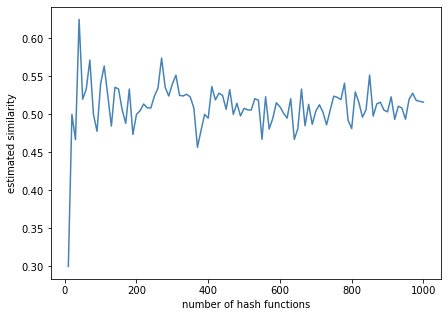

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plt.plot(nhash_trials, sims, color="steelblue")
plt.xlabel("number of hash functions")
plt.ylabel("estimated similarity")
plt.show()